In [1]:
from functools import partial
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from CIFARLoader import save_cifar_fit, check_cifar, check_output_path
import easydict 


In [2]:
VALIDATION_SPLIT = 0.1

train_datagen = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False,
    featurewise_std_normalization=True, 
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range= 0.2, 
    shear_range= 0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=VALIDATION_SPLIT
)

test_datagen = ImageDataGenerator(featurewise_center=True,
                                  samplewise_center=False,
                                  featurewise_std_normalization=True,
                                  samplewise_std_normalization=False,
                                  zca_whitening=False,
                                  zca_epsilon=1e-06,
                                  rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                  )

In [3]:
OUTPUT_DIR = 'cifar10_data'

In [4]:
args = easydict.EasyDict({
    "dataset": "cifar10",
    "output": "cifar10_data",
    "name_with_batch_index": False
})

if check_cifar(args.dataset) :
    save_cifar_fit(args, train_datagen, test_datagen)


Saving train images: 100%|██████████| 50000/50000 [00:18<00:00, 2642.44it/s]


                     /-\|/-\|/-\|/

Saving test images: 100%|██████████| 10000/10000 [00:03<00:00, 2632.03it/s]


In [5]:
import glob

IMAGE_COUNT = len(glob.glob(OUTPUT_DIR + '/' + 'train'  + '/*/*'))

print(IMAGE_COUNT)

50000


In [6]:
BATCH_SIZE = 100

STEPS_PER_EPOCH = np.ceil((IMAGE_COUNT - IMAGE_COUNT * VALIDATION_SPLIT)/BATCH_SIZE)

IMAGE_COUNT, STEPS_PER_EPOCH

(50000, 450.0)

In [7]:
TARGET_SIZE = (227, 227)

train_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'train', 
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    subset='training',
    shuffle=True,
    seed=42
)
validation_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


Alexnet

In [8]:
DefaultAlexConv2D = partial(keras.layers.Conv2D, strides=(1, 1) , activation = tf.nn.relu)
DefaultAlexMaxPool2D = partial(keras.layers.MaxPool2D, pool_size=(3, 3),  strides = (2, 2))
DefaultBatchNormalize = partial(tf.keras.layers.BatchNormalization)
DefaultDropout = partial(tf.keras.layers.Dropout, rate = 0.5)

In [9]:
from datetime import datetime

date_time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")

alex_net_model = keras.models.Sequential([
    DefaultAlexConv2D(filters=96, kernel_size=(11, 11),  strides=(4, 4), 
                      input_shape=(227, 227, 3), padding='VALID'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(), 
    DefaultAlexConv2D(filters = 256, kernel_size = (5, 5), padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(), 
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 256, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    ], name="alex_net_model_" + date_time)

In [10]:
alex_net_model.summary()

Model: "alex_net_model_02_03_2022_02_37_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (No

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,_,logs={}):
        if (logs.get("accuracy")==0.98 and logs.get("loss")<0.03):
            print("\nReached 98% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

In [12]:
alex_net_model.compile(loss=tf.losses.CategoricalCrossentropy(), metrics=[
                       'accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))

history = alex_net_model.fit(train_generator,validation_data=validation_generator,
    callbacks=[callbacks], verbose=2, workers=16, 
    epochs=50, steps_per_epoch=STEPS_PER_EPOCH)


Epoch 1/50
450/450 - 81s - loss: 2.0299 - accuracy: 0.3266 - val_loss: 1.8024 - val_accuracy: 0.3420
Epoch 2/50
450/450 - 62s - loss: 1.5637 - accuracy: 0.4344 - val_loss: 1.4196 - val_accuracy: 0.4784
Epoch 3/50
450/450 - 61s - loss: 1.4196 - accuracy: 0.4923 - val_loss: 1.2987 - val_accuracy: 0.5510
Epoch 4/50
450/450 - 62s - loss: 1.3089 - accuracy: 0.5326 - val_loss: 1.2330 - val_accuracy: 0.5558
Epoch 5/50
450/450 - 63s - loss: 1.2204 - accuracy: 0.5653 - val_loss: 1.2549 - val_accuracy: 0.5704
Epoch 6/50
450/450 - 61s - loss: 1.1403 - accuracy: 0.5953 - val_loss: 1.1367 - val_accuracy: 0.6074
Epoch 7/50
450/450 - 64s - loss: 1.0811 - accuracy: 0.6183 - val_loss: 1.0283 - val_accuracy: 0.6542
Epoch 8/50
450/450 - 63s - loss: 1.0221 - accuracy: 0.6392 - val_loss: 0.9823 - val_accuracy: 0.6694
Epoch 9/50
450/450 - 61s - loss: 0.9727 - accuracy: 0.6592 - val_loss: 0.9667 - val_accuracy: 0.6742
Epoch 10/50
450/450 - 61s - loss: 0.9203 - accuracy: 0.6766 - val_loss: 0.9790 - val_accura

In [13]:
test_generator = test_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'test', target_size=TARGET_SIZE)


Found 10000 images belonging to 10 classes.


In [14]:
score = alex_net_model.evaluate(test_generator, workers=16,verbose=2)

313/313 - 16s - loss: 0.4762 - accuracy: 0.8417


Training accuracy:  0.8964444398880005
Training loss:  0.3026216924190521
Validation accuracy:  0.8510000109672546
Validation loss:  0.45269668102264404


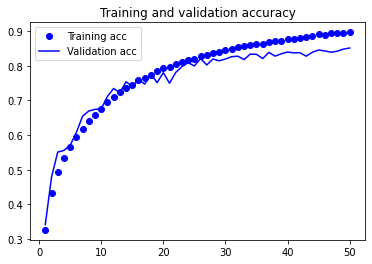

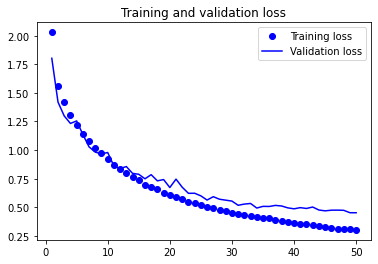

In [15]:

acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)

print("Validation accuracy: ", val_acc)
print("Validation loss: ", val_loss)

# Plotting the graphs to visualize the trend of accuracy and loss

epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
alex_net_model.save('alex_net_model_' + date_time + '.h5')
